In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten, Dense,MaxPool2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow. keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
img_height, img_width = (224,224)
batch_size = 32
train_data_dir = "/content/drive/MyDrive/Internships/I'mbesideyou/Train_Val/train"
valid_data_dir = "/content/drive/MyDrive/Internships/I'mbesideyou/Train_Val/val"
test_data_dir = "/content/drive/MyDrive/Internships/I'mbesideyou/test"

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
                  train_data_dir,
                  target_size=(img_height, img_width),
                  batch_size=batch_size,
                  class_mode='categorical',
                  subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
                  valid_data_dir, # same directory as training data
                  target_size=(img_height, img_width),
                  batch_size=batch_size,
                  class_mode= 'categorical',
                  subset='validation') # set as validation data
# print(train_generator, valid_generator)

Found 2318 images belonging to 3 classes.
Found 386 images belonging to 3 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory(
                test_data_dir, # same directory as training data
                target_size=(img_height, img_width),
                batch_size=1,
                class_mode='categorical',
                subset='validation') # set as validation data

Found 643 images belonging to 3 classes.


In [ ]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)

x = Dense(512, activation='relu')(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:
model.fit(train_generator,
steps_per_epoch = len(train_generator),
epochs= 30,
validation_data= valid_generator)

Epoch 1/30
73/73 [==============================] - 512s 7s/step - loss: 0.7984 - accuracy: 0.6984 - val_loss: 0.7065 - val_accuracy: 0.7202
Epoch 2/30
73/73 [==============================] - 505s 7s/step - loss: 0.7060 - accuracy: 0.7222 - val_loss: 0.6880 - val_accuracy: 0.7383
Epoch 3/30
73/73 [==============================] - 502s 7s/step - loss: 0.6592 - accuracy: 0.7433 - val_loss: 0.7030 - val_accuracy: 0.7202
Epoch 4/30
73/73 [==============================] - 499s 7s/step - loss: 0.6284 - accuracy: 0.7528 - val_loss: 0.6613 - val_accuracy: 0.7746
Epoch 5/30
73/73 [==============================] - 501s 7s/step - loss: 0.6029 - accuracy: 0.7653 - val_loss: 0.7078 - val_accuracy: 0.7409
Epoch 6/30
73/73 [==============================] - 501s 7s/step - loss: 0.5944 - accuracy: 0.7748 - val_loss: 0.6419 - val_accuracy: 0.7798
Epoch 7/30
73/73 [==============================] - 500s 7s/step - loss: 0.5808 - accuracy: 0.7722 - val_loss: 0.6583 - val_accuracy: 0.7565
Epoch 8/30
73

In [ ]:
model.save("/content/drive/MyDrive/Internships/I'mbesideyou/saved_model/ResNet_model.h5")

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print ('InTest accuracy:', test_acc)

643/643 - 357s - loss: 0.8633 - accuracy: 0.7294 - 357s/epoch - 555ms/step
InTest accuracy: 0.729393482208252


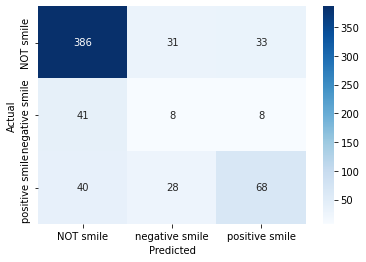

test accuracy : 71.85069984447901


In [ ]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/Internships/I'mbesideyou/saved_model/ResNet_model.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  x_test, y_test = test_generator.next()
  y_prob.append(model.predict(x_test))
  y_act.append(y_test)
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]
out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()
print('test accuracy : {}'.format ((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
result=model.evaluate(test_generator)

643/643 [==============================] - 153s 235ms/step - loss: 0.8396 - accuracy: 0.7247
